How to run a code with stopping conditions
====================

Stopping conditions should be considered interrupts that are initiated through special conditions in the running code. Stopping conditions leave the running code in a restartable state while exiting the code to hand the control back to the python (i.e. the AMUSE) script. There are stopping conditions in most codes, but here we only discuss one of them in the stellar dynamics codes, which is called: *collision_detection*

For reference you can read chapter 2 of Portegies Zwart & McMillan 2018 (2018araa.book.....P). 

With this tutorial you will learn
- how to generate inital conditions (mass-function, King-model)
- to initialize an gravitational N-body code
- channels and intra-code data transfer
- detecting collisions
- plotting results
- making Hertzsprung-Russell diagrams

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(98429435)
from matplotlib import pyplot as plt
from amuse.units import units

Let's start by generating the initial conditions and initializing the N-body code.

In [2]:
n_stars = 100
alpha_IMF = -2.35

from amuse.lab import new_powerlaw_mass_distribution
m_stars = new_powerlaw_mass_distribution(n_stars, 
                                         10.0|units.MSun, 
                                         100.0|units.MSun, 
                                         alpha_IMF)

r_cluster = 1.0 | units.parsec
from amuse.units import nbody_system
converter=nbody_system.nbody_to_si(m_stars.sum(), r_cluster)
from amuse.ic.plummer import new_plummer_model
stars=new_plummer_model(n_stars, convert_nbody=converter)
stars.mass = m_stars
setattr(stars, "collision_radius", 0|units.RSun)
stars.scale_to_standard(converter)

from amuse.community.ph4.interface import ph4
from amuse.community.seba.interface import SeBa
from amuse.ext.LagrangianRadii import LagrangianRadii

stellar = SeBa()
stellar.particles.add_particles(stars)

gravity = ph4(converter, number_of_workers=6)
gravity.particles.add_particles(stars)

Now let's declare the channels.
This is somewhat more elaborate here, because there is a new parameter to declare, which is *collision_radius*.
The parameter is needed in order to ensure that our stellar collisions behave as expected.

In [3]:
stellar_attributes = ["mass", "radius", "age", "temperature", "luminosity"]
channel = {"from_stellar":
              stellar.particles.new_channel_to(stars,
              attributes=stellar_attributes,
              target_names=stellar_attributes),
            "from_gravity": 
              gravity.particles.new_channel_to(stars,
              attributes=["x", "y", "z", "vx", "vy", "vz", "mass"],
              target_names=["x", "y", "z", "vx", "vy", "vz", "mass"]),
            "to_gravity": 
              stars.new_channel_to(gravity.particles,
              attributes=["mass", "collision_radius"],
              target_names=["mass", "radius"])}
    
channel["from_stellar"].copy()

We here explicitely copied particle attributes which we think are of interesting for this experiment, including stellar mass, radius, age, temperature and luminosity.

##### *collision_radius*
An additional parameter was introduced to keep track of the collisional radius for the stars. Stars tend to be small compared to the inter-stellar distance. In order to warrant some nice collisions in our simulation we may want to expand the stellar size in comparison with the equilibrium photospheric radius of the stars. We can do this by adding an additional parameter, here called *collision_radius* to the particle set. Notice that the *collision_radius* is copied into the attribute *radius* of the stars in the N-body code, because there is no separate collision-radius in the N-body code, but the attribute *radius* is used to check for two objects to come close before an exception is thrown.

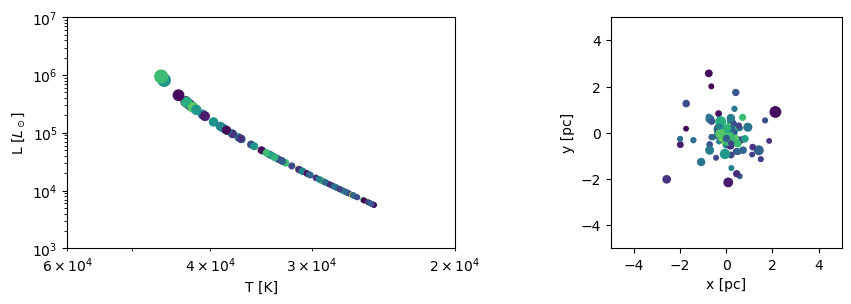

In [4]:
def plot_snapshot(bodies):
    v = (bodies.vx**2 + bodies.vy**2 + bodies.vz**2).sqrt()
    s = bodies.mass.value_in(units.MSun)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))
    ax1.scatter(stars.temperature.value_in(units.K),
                stars.luminosity.value_in(units.LSun), 
                c=v.value_in(units.kms),
                s=s)
    ax1.set_xlim(6.e+4, 20000)
    ax1.set_ylim(1.e+3, 1.e+7)
    ax1.loglog()
    ax1.set_xlabel("T [K]")
    ax1.set_ylabel("L [$L_\odot$]")
    ax2.scatter(bodies.x.value_in(units.pc), 
                bodies.y.value_in(units.pc), 
                c=v.value_in(units.kms), 
                s=s)
    plt.gca().set_aspect('equal', adjustable='box')
    ax2.set_xlabel("x [pc]")
    ax2.set_ylabel("y [pc]")
    ax2.set_xlim(-5, 5)
    ax2.set_ylim(-5, 5)
    plt.show()
plot_snapshot(stars)

Now initiate the stopping conditions in order to detect a merger between two stars.

In [5]:
stopping_condition = gravity.stopping_conditions.collision_detection
stopping_condition.enable()
collision_radius_multiplication_factor = 1000

We introduced a multiplication factor in order to acquire many nice collisions.

In [6]:
def merge_two_stars(bodies, particles_in_encounter):
    com_pos = particles_in_encounter.center_of_mass()
    com_vel = particles_in_encounter.center_of_mass_velocity()
    d = (particles_in_encounter[0].position - particles_in_encounter[1].position)
    v = (particles_in_encounter[0].velocity - particles_in_encounter[1].velocity)
    print("Actually merger occurred:")
    print("Two stars (M=",particles_in_encounter.mass.in_(units.MSun),
          ") collided with d=", d.length().in_(units.au))
    new_particle=Particles(1)
    new_particle.mass = particles_in_encounter.total_mass()
    new_particle.age = min(particles_in_encounter.age) \
                     * max(particles_in_encounter.mass)/new_particle.mass
    new_particle.position = com_pos
    new_particle.velocity = com_vel
    new_particle.radius = particles_in_encounter.radius.sum()
    bodies.add_particles(new_particle)
    bodies.remove_particles(particles_in_encounter)

When two stars collide, we will merge with the function above. We create a new particle with the summed mass of the two merged stars, and remove the old stars. What quantities are conserved during this merger process?

In [7]:
from amuse.lab import Particles
def resolve_collision(collision_detection, gravity, stellar, bodies):
    if collision_detection.is_set():
        print("Well, we have an actual collision between two or more stars.")
        print("This happened at time=", stellar.model_time.in_(units.Myr))
        for ci in range(len(collision_detection.particles(0))): 
            encountering_particles = Particles(particles=[collision_detection.particles(0)[ci],
                                                          collision_detection.particles(1)[ci]])
            colliding_stars = encountering_particles.get_intersecting_subset_in(bodies)
            merge_two_stars(bodies, colliding_stars)
            bodies.synchronize_to(gravity.particles)
            bodies.synchronize_to(stellar.particles)

The collision detector is a separate object from the code. If this is triggered, we process all pairs of stars that have collided.

In [8]:
end_time = 10.0 | units.Myr
model_time = 0 | units.Myr
rvir = [] | units.pc
time = [] | units.Myr
t_diag = 1| units.Myr
while(model_time<end_time):
    dt = stellar.particles.time_step.min()
    model_time += dt
    stellar.evolve_model(model_time)
    channel["from_stellar"].copy()
    stars.collision_radius = stars.radius * collision_radius_multiplication_factor
    channel["to_gravity"].copy()
    gravity.evolve_model(model_time)
    resolve_collision(stopping_condition, gravity, stellar, stars)
    channel["from_gravity"].copy()
    
    if model_time >= t_diag:
        t_diag += 1 | units.Myr

        print("Evolved to t=", stellar.model_time.in_(units.Myr), 
              gravity.model_time.in_(units.Myr),
              "N=", len(stars),
              "mass=", stars.mass.sum().in_(units.MSun), 
              "rvir=", stars.virial_radius().in_(units.pc))
        #pos,coreradius,coredens = stars.densitycentre_coreradius_coredens()
    rvir.append(stars.virial_radius())
    time.append(model_time)
    
stellar.stop()
gravity.stop()

Evolved to t= 1.01565962941 Myr 1.01580518685 Myr N= 100 mass= 1996.09304421 MSun rvir= 1.10481180576 parsec
Evolved to t= 2.01497477654 Myr 2.01509321618 Myr N= 100 mass= 1966.85194944 MSun rvir= 0.933787804371 parsec
Evolved to t= 3.0091689202 Myr 3.00919939218 Myr N= 100 mass= 1934.39017179 MSun rvir= 1.04591310915 parsec
Well, we have an actual collision between two or more stars.
This happened at time= 3.28894462455 Myr
Actually merger occurred:
Two stars (M= [15.8770700381, 62.5778007016] MSun ) collided with d= 16463.1884693 au
Evolved to t= 4.00048045042 Myr 4.00103850735 Myr N= 99 mass= 1862.28424787 MSun rvir= 1.38984791985 parsec
Well, we have an actual collision between two or more stars.
This happened at time= 4.6772709763 Myr
Actually merger occurred:
Two stars (M= [33.4981890944, 9.80583306532] MSun ) collided with d= 9914.70594436 au
Well, we have an actual collision between two or more stars.
This happened at time= 4.72030513165 Myr
Actually merger occurred:
Two stars 

In [48]:
from amuse.units.generic_unit_converter import ConvertBetweenGenericAndSiUnits
from amuse.units import units, constants
converter = ConvertBetweenGenericAndSiUnits(constants.c, units.s)
print(converter.to_generic(constants.c))
print(stars.densitycentre_coreradius_coredens(unit_converter=converter))
# gives error: 
# "AmuseException: error while converting parameter 'mass', 
# error: Cannot express kg in mass, the units do not have the same bases 
# (note: check whether Hop needs a converter here)"

# how do i know whether Hop needs a converter?

1.0 length * time**-1


AmuseException: error while converting parameter 'mass', error: Cannot express kg in mass, the units do not have the same bases (note: check whether Hop needs a converter here)

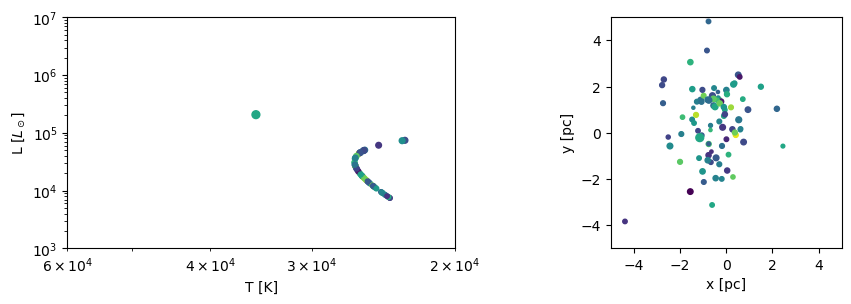

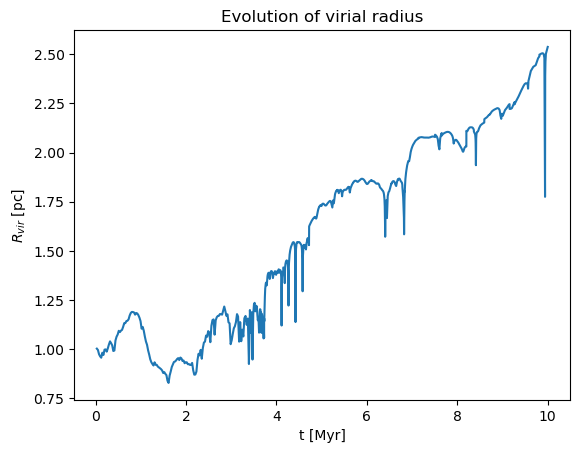

In [22]:
plot_snapshot(stars)
plt.plot(time.value_in(units.Myr), rvir.value_in(units.parsec))
plt.xlabel("t [Myr]")
plt.ylabel("$R_{vir}$ [pc]")
plt.title("Evolution of virial radius")
plt.show()

You have calculated the evolution of a small cluster of 100 stars. Your calculation included Newtonian dynamics, stellar evolution and collisions.
The collisions were rather simple, sticky spheres, and we have chosen the stellar radii to be a 1000 times larger than normal.

Assignments and questions:
---------------

### Question 1:

 * Why did we run with a random seed? <span style="color:purple;font-weight:700">For reproducability</span>
 * How many collisions did occur? <span style="color:purple;font-weight:700">Four</span>
 * What are these curious stars that are not on the main sequence in the Hertzsprung-Russel diagram? <span style="color:purple;font-weight:700">[answer]</span>
 * Where in the cluster (with respect to the core-radius and virial-radius) are the collision products? Note that the core radius can be acquired at runtime from the particle set via the member function: *stars.densitycentre_coreradius_coredens* (which returns the position vector of the density centre, the core radius, and the core density). <span style="color:purple;font-weight:700">[answer]</span>
 
### Assignment 1:
Include the appropriate diagnostics in the script in order to address the following questions:
 
 * What was the distance from the cluster center where the collissions took place?
 * What is the amount of energy that has been dissipated in the collisions?
 * What is the actual numerical energy error in the calculation?

### Assignment 2:
We assumed that mass and momentum are conserved in the collision process. Change the script in such a way that the mass of the collision product is the sum of the primary mass and half that of the secondary.
Rerun the script and explain the differences.

### Questions 2:

 * Has the change affected the number of collisions?
 * What change do you see in the Hertzsprung-Russel diagram?
 * What happened to the cluster virial radius?
 
### Questions 3:
Considerable magic seems to be happening in the routine *resolve_collision*.

 * explain what happens in the following lines:
```python
   encountering_particles = Particles(
       particles=[collision_detection.particles(0)[ci],
       collision_detection.particles(1)[ci]])
```
 
 * and what happens in:
```python
colliding_stars = encountering_particles.get_intersecting_subset_in(bodies)
```

 * and in:
```python
bodies.synchronize_to(gravity.particles)
bodies.synchronize_to(stellar.particles)
```

### Assignment 4:
 * Write a one-line python script to find the brighest star.